<h1 style="color:blue"> Multiclass classification model using a custom CNN in tensorflow</h1>

**Objective :** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Importing libraries

In [1]:
import pathlib
import tensorflow as tf

import numpy as np
import pandas as pd

import os
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
%matplotlib inline 

## Defining constants

In [2]:
SEED = 123
BATCH = 32
EPOCHS = 20

BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("./Train/")
data_dir_test = pathlib.Path('./Test/')

## Loading data

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(f"Total images in train = {image_count_train}")

image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f"Total images in test = {image_count_test}")

Total images in train = 2239
Total images in test = 0


<p style="color: red">NOTE THAT WE'LL BE USING TRAIN DATA TO TRAIN OUR MODEL SPLITTING IT INTO TRAIN AND VALIDATION DATA CHUNKS</p>

In [5]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train, 
                                                               seed=SEED, validation_split=0.2, subset = "training",
                                                               batch_size=BATCH_SIZE, image_size=(IMG_HEIGHT,IMG_WIDTH))

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
# validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train, 
                                                               seed=SEED, validation_split=0.2, subset = "validation",
                                                            batch_size=BATCH_SIZE, image_size=(IMG_HEIGHT,IMG_WIDTH))

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# Listing all the classes
class_names = train_ds.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

### Visualizing one instance of all the nine classes present in the dataset

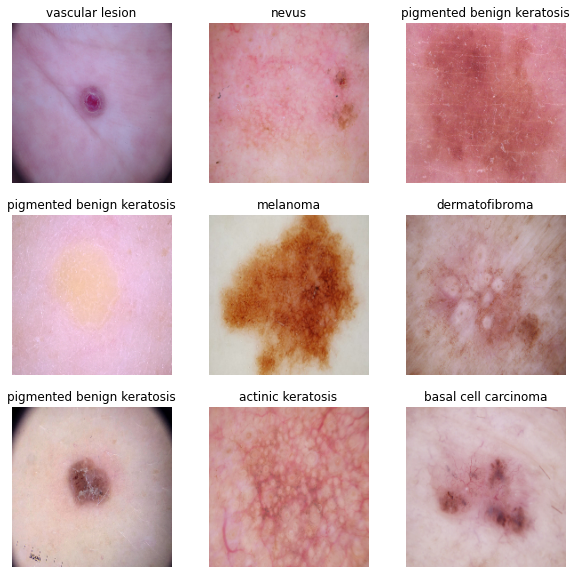

In [8]:
# visualizing the loaded data

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Prefetching

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Modeling

## Building CNN

#### Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [10]:
# Creating CNN

num_classes = 9

model = Sequential([
  # Layer set -1                  
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.Conv2D(32, kernel_size=(3, 3),activation='relu'),
  layers.Conv2D(32,kernel_size=(3, 3), activation='relu'),
  layers.MaxPool2D(pool_size = (2, 2)),

  # Layer set -2
  layers.Conv2D(64, (3, 3), activation='relu',padding = 'Same'),
  layers.Conv2D(64, (3, 3), activation='relu',padding = 'Same'),
  layers.MaxPool2D(pool_size=(2, 2)),

  # Layer set -3
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [11]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 176, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 88, 88, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 88, 88, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 44, 44, 64)        0

In [13]:
# fitting our model
history = model.fit(train_ds, batch_size=BATCH, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/20


C:\Users\sonia\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


56/56 [==============================] - 152s 3s/step - loss: 2.3475 - accuracy: 0.2567 - val_loss: 1.7361 - val_accuracy: 0.3691
Epoch 2/20
56/56 [==============================] - 137s 2s/step - loss: 1.6731 - accuracy: 0.4079 - val_loss: 1.7186 - val_accuracy: 0.3579
Epoch 3/20
56/56 [==============================] - 148s 3s/step - loss: 1.5126 - accuracy: 0.4688 - val_loss: 1.7890 - val_accuracy: 0.3893
Epoch 4/20
56/56 [==============================] - 136s 2s/step - loss: 1.4397 - accuracy: 0.4810 - val_loss: 1.4990 - val_accuracy: 0.4497
Epoch 5/20
56/56 [==============================] - 130s 2s/step - loss: 1.3300 - accuracy: 0.5190 - val_loss: 1.4422 - val_accuracy: 0.5101
Epoch 6/20
56/56 [==============================] - 131s 2s/step - loss: 1.2252 - accuracy: 0.5547 - val_loss: 1.5396 - val_accuracy: 0.4922
Epoch 7/20
56/56 [==============================] - 130s 2s/step - loss: 1.1091 - accuracy: 0.6004 - val_loss: 1.7394 - val_accuracy: 0.4609
Epoch 8/20
56/56 [======

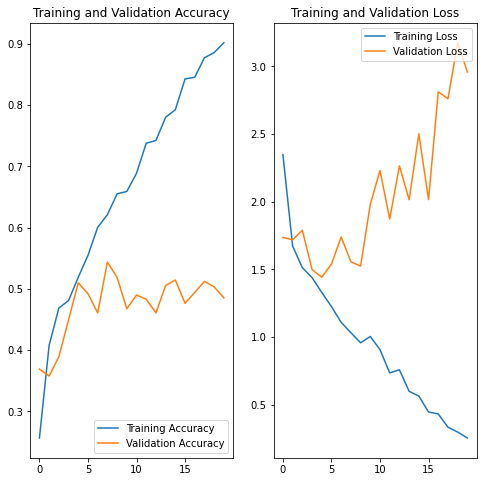

In [14]:
# Visualizing model metrices
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The above model is clearly overfitting since the training accuracy, is greater than the validation accuracy by leaps and bounds
Also in terms of ‘loss’, overfitting reveals itself when our model show a low values for the training loss and a higher values in the validation loss.

**Hence the model is Overfitting
To overcome overfitting we'll be adding Dropout and Data Argumentation layers to randomize the data and decrease overfitting**

### Data Argumentation

In [15]:
# data argumentation layer

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed=SEED),
  layers.experimental.preprocessing.RandomRotation(0.2, seed=SEED),
  layers.experimental.preprocessing.RandomZoom(height_factor=(-0.5, 0.5), width_factor=(-0.5, 0.5), fill_mode='reflect',interpolation='bilinear', seed=SEED),
  
])

<Figure size 1440x1440 with 0 Axes>

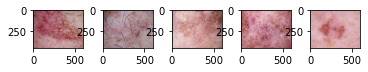

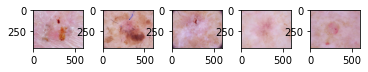

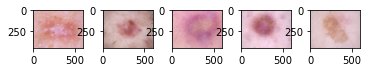

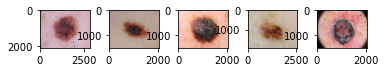

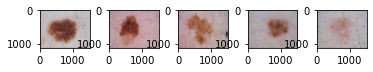

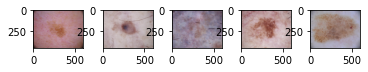

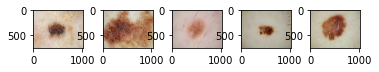

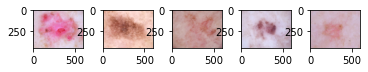

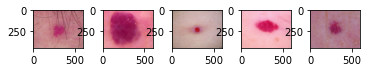

In [16]:
# visualizing argumented data from each class(5 samples from each class type)

plt.figure(figsize=(20, 20))
directory=os.listdir(data_dir_train)
for each in directory:
    plt.figure()
    # print(f"EACH - {each} ------- {data_dir_train}")
    currentFolder = f"{data_dir_train}/{each}"
    # print(f"FOLDER == {currentFolder}")
    for i, file in enumerate(os.listdir(currentFolder)[0:5]):
        # print(f"{currentFolder}/{file}")
        fullpath = f"{currentFolder}/{file}"
        # print(fullpath)
        img=plt.imread(fullpath)
        plt.subplot(5,5,i+1)
        # plt.title(class_names[labels[i]])
        plt.imshow(img)

### Re-Creating the CNN with data argumentation and dropout layers to avoid overfitting

In [17]:
# Creating CNN
model = Sequential([
  # Layer set -1                  
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  data_augmentation,
  layers.Conv2D(32, kernel_size=(3, 3),activation='relu'),
  layers.Conv2D(32,kernel_size=(3, 3), activation='relu'),
  layers.MaxPool2D(pool_size = (2, 2)),
  layers.Dropout(0.15),

  # Layer set -2
  layers.Conv2D(64, (3, 3), activation='relu',padding = 'Same'),
  layers.Conv2D(64, (3, 3), activation='relu',padding = 'Same'),
  layers.MaxPool2D(pool_size=(2, 2)),
  layers.Dropout(0.2),

  # Layer set -3
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])

In [18]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 176, 176, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 88, 88, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 88, 88, 64)       

In [20]:
# fitting our model
history = model.fit(train_ds, batch_size=BATCH, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/20
56/56 [==============================] - 129s 2s/step - loss: 2.2478 - accuracy: 0.2070 - val_loss: 1.8743 - val_accuracy: 0.3535
Epoch 2/20
56/56 [==============================] - 125s 2s/step - loss: 1.9967 - accuracy: 0.2545 - val_loss: 1.8648 - val_accuracy: 0.3669
Epoch 3/20
56/56 [==============================] - 128s 2s/step - loss: 1.8065 - accuracy: 0.3393 - val_loss: 1.7476 - val_accuracy: 0.3848
Epoch 4/20
56/56 [==============================] - 130s 2s/step - loss: 1.7236 - accuracy: 0.3811 - val_loss: 1.5698 - val_accuracy: 0.4407
Epoch 5/20
56/56 [==============================] - 123s 2s/step - loss: 1.7000 - accuracy: 0.4029 - val_loss: 1.8113 - val_accuracy: 0.3087
Epoch 6/20
56/56 [==============================] - 126s 2s/step - loss: 1.7000 - accuracy: 0.3940 - val_loss: 1.6529 - val_accuracy: 0.3848
Epoch 7/20
56/56 [==============================] - 123s 2s/step - loss: 1.6721 - accuracy: 0.4040 - val_loss: 1.6272 - val_accuracy: 0.3915
Epoch 8/20
56

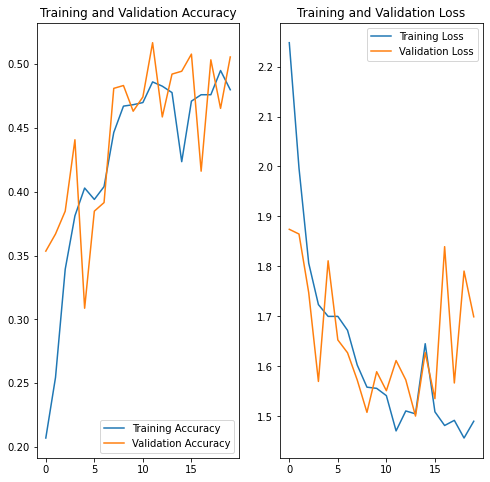

In [21]:
# Visualizing model metrices
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can visualize that the issue of overfitting is resolved now and our model is more generalized. But the accuracy of the model is still quite low. 

This might be a result of less number of samples available for training our model.

Let's observe number of samples present in each class

In [22]:
directory=os.listdir(data_dir_train)
for each in directory:
    currentFolder = f"{data_dir_train}/{each}"
    print(f"Class Name => {each}")
    print(f"--------------- Class length =>{len(os.listdir(currentFolder))}")

Class Name => actinic keratosis
--------------- Class length =>114
Class Name => basal cell carcinoma
--------------- Class length =>376
Class Name => dermatofibroma
--------------- Class length =>95
Class Name => melanoma
--------------- Class length =>438
Class Name => nevus
--------------- Class length =>357
Class Name => pigmented benign keratosis
--------------- Class length =>462
Class Name => seborrheic keratosis
--------------- Class length =>77
Class Name => squamous cell carcinoma
--------------- Class length =>181
Class Name => vascular lesion
--------------- Class length =>139


**Hence class `seborrheic keratosis` has least number of samples and class `pigmented benign keratosis` has most number of samples**

This is a class imbalance problem. Lets resolve it...

## Image class imbalance problem treatment

In [23]:
# generating 500 argumented for each sample
import Augmentor

directory=os.listdir(data_dir_train)
for each in class_names:
    currentFolder = f"{data_dir_train}/{each}"
    p = Augmentor.Pipeline(currentFolder)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C23C0CD610>: 100%|█| 500/500 [00:08<00:00, 61.26 Samples/
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1C22A745F40>: 100%|█| 500/500 [00:07<00:
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C23C11C910>: 100%|█| 500/500 [00:08<00:00, 61.39 Samples/
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x1C238F2F340>: 100%|█| 500/500 [00:33<00:00, 15.14 Sample
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=962x723 at 0x1C23C11CD60>:   0%| | 1/500 [00:00<01:27

Initialised with 357 image(s) found.
Output directory set to Train/nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x1C22A926220>: 100%|█| 500/500 [00:33<00:
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1C22A566AC0>: 100%|█| 500/500 [00:07<00:
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1C22A842700>: 100%|█| 500/500 [00:16<00:00, 30.95 Samples
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C226EDD040>: 100%|█| 500/500 [00:06<00:00, 75.32 Samples/
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1C23C114910>: 100%|█| 500/500 [00:06<00:


In [24]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
image_count_train

4500

**Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.**

### Lets see the distribution of augmented data after adding new images to the original training data.

In [25]:
directory=os.listdir(data_dir_train)
for each in directory:
    currentFolder = f"{data_dir_train}/{each}"
    old_class_length = len(os.listdir(currentFolder))
    new_class_length = len(os.listdir(f"{currentFolder}/output/"))
    print(f"Class Name => {each}")
    print(f"--------------- Class length =>{old_class_length+new_class_length}")

Class Name => actinic keratosis
--------------- Class length =>615
Class Name => basal cell carcinoma
--------------- Class length =>877
Class Name => dermatofibroma
--------------- Class length =>596
Class Name => melanoma
--------------- Class length =>939
Class Name => nevus
--------------- Class length =>858
Class Name => pigmented benign keratosis
--------------- Class length =>963
Class Name => seborrheic keratosis
--------------- Class length =>578
Class Name => squamous cell carcinoma
--------------- Class length =>682
Class Name => vascular lesion
--------------- Class length =>640


## lets train the model on the data created using Augmentor

In [26]:
data_dir_train_new = data_dir_train

#new training dataset
train_ds_new = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=SEED,
  validation_split = 0.2,
  subset = "training",
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [27]:
# new validation dataset
val_ds_new = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train, 
                                                               seed=SEED, validation_split=0.2, subset = "validation",
                                                            batch_size=BATCH_SIZE, image_size=(IMG_HEIGHT,IMG_WIDTH))

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


# Lets create a CNN based on new training data

In [28]:
# Creating CNN
model_new = Sequential([
  # Layer set -1                  
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.Conv2D(32, kernel_size=(3, 3),activation='relu'),
  layers.Conv2D(32,kernel_size=(3, 3), activation='relu'),
  layers.MaxPool2D(pool_size = (2, 2)),
  layers.Dropout(0.15),

  # Layer set -2
  layers.Conv2D(64, (3, 3), activation='relu',padding = 'Same'),
  layers.Conv2D(64, (3, 3), activation='relu',padding = 'Same'),
  layers.MaxPool2D(pool_size=(2, 2)),
  layers.Dropout(0.2),

  # Layer set -3
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])

In [29]:
# Compile the model
model_new.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
# View the summary of all layers
model_new.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 176, 176, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 88, 88, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 88, 88, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 88, 88, 64)       

In [31]:
# fitting our model
history = model_new.fit(train_ds_new, batch_size=BATCH, validation_data=val_ds_new, epochs=30)

Epoch 1/30
169/169 [==============================] - 418s 2s/step - loss: 2.2395 - accuracy: 0.1330 - val_loss: 2.1911 - val_accuracy: 0.1403
Epoch 2/30
169/169 [==============================] - 401s 2s/step - loss: 2.1801 - accuracy: 0.1447 - val_loss: 2.1875 - val_accuracy: 0.1448
Epoch 3/30
169/169 [==============================] - 430s 3s/step - loss: 2.1333 - accuracy: 0.1747 - val_loss: 2.0718 - val_accuracy: 0.2153
Epoch 4/30
169/169 [==============================] - 347s 2s/step - loss: 2.0082 - accuracy: 0.2257 - val_loss: 1.8521 - val_accuracy: 0.2747
Epoch 5/30
169/169 [==============================] - 398s 2s/step - loss: 1.8323 - accuracy: 0.2828 - val_loss: 1.7682 - val_accuracy: 0.2932
Epoch 6/30
169/169 [==============================] - 396s 2s/step - loss: 1.7154 - accuracy: 0.3349 - val_loss: 1.5647 - val_accuracy: 0.4150
Epoch 7/30
169/169 [==============================] - 385s 2s/step - loss: 1.5602 - accuracy: 0.3945 - val_loss: 1.4389 - val_accuracy: 0.4840

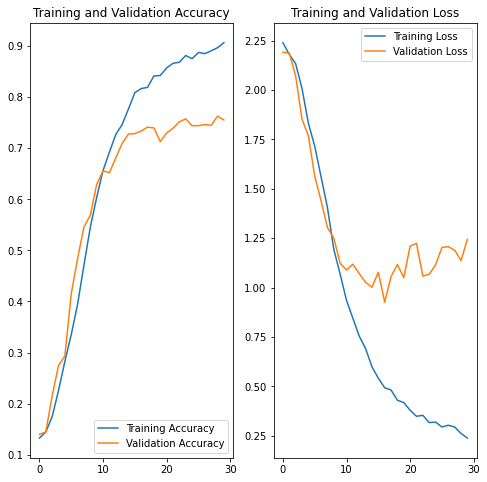

In [32]:
# Visualizing model metrices
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### As we can see that this model had a decent amount of accuracy and also the problem of overfitting is fixed (accuracy and validation accuracies are nearly the same, similar trend occurs with respective losses)

### Therefore we may accept this model to make further predictions, as it is both accurate and generalized in nature.